<center>
    <h1 style="color:DarkRed;font-size:40px"><b>House Prices - Advanced Regression Techniques</b></h1>
</center>

<center><img src="house.jpeg" width=600 height=400 />

# **Descrição do problema**

Este notebook será utilizado para resolução do problema proposto na <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview">Competição House Price Prediction</a>, disponibilizada pelo Kaggle. O objetivo é prever o valor das casas com base numa série de atributos, como tamanho, número de quartos, etc.

Com isso em mente, ao longo deste notebook serão desenvolvidas as tarefas:
- Análise exploratória, limpeza e manipulação dos dados;
- Criação de gráficos para visualização dos dados;
- Construção de modelos preditivos, buscando testar diferentes algoritmos de regressão.

# **Importação das bibliotecas**

In [19]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **Análise exploratória, limpeza e manipulação dos dados**

In [2]:
#carregando o conjunto de dados de treino
dados_treino = pd.read_csv('Dados/train.csv', index_col = 'Id')
dados_treino.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
dados_treino.shape

(1460, 80)

In [4]:
#quantidade de dados categóricos e numéricos (-1 de SalePrice)
quantidade_categoricos = dados_treino.select_dtypes('object').shape[1]
quantidade_numericos = dados_treino.select_dtypes(exclude=['object']).shape[1] - 1
print('Quantidade de dados categóricos: %d' % quantidade_categoricos)
print('Quantidade de dados numéricos: %d' % quantidade_numericos)

Quantidade de dados categóricos: 43
Quantidade de dados numéricos: 36


In [5]:
#verificando se há valores duplicados
dados_treino.duplicated().sum()

0

In [6]:
#verificando presença de valores nulos
dados_treino.isnull().sum()[dados_treino.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [ ]:
profile = ProfileReport(dados_treino)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Histograma dos Valores de Tamanho de Fachada')

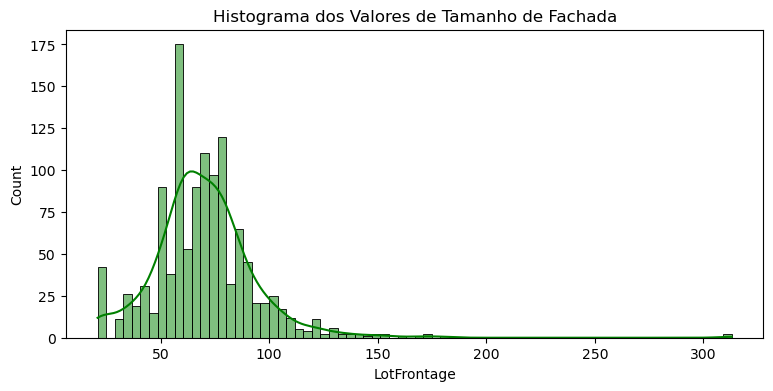

In [18]:
plt.figure(figsize=(9,4))
sns.histplot(dados_treino.LotFrontage, kde = True, legend = False, color = 'green')
plt.title('Histograma dos Valores de Tamanho de Fachada', fontsize = 12)

Text(0.5, 1.0, 'Histograma dos Valores de Venda')

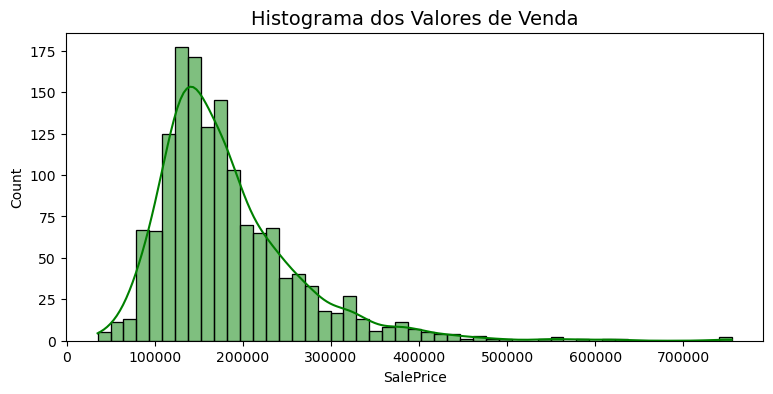

In [17]:
#distribuição dos valores de venda
plt.figure(figsize=(9,4))
sns.histplot(dados_treino.SalePrice, kde = True, legend = False, color = 'green')
plt.title('Histograma dos Valores de Venda', fontsize = 14)

<AxesSubplot:>

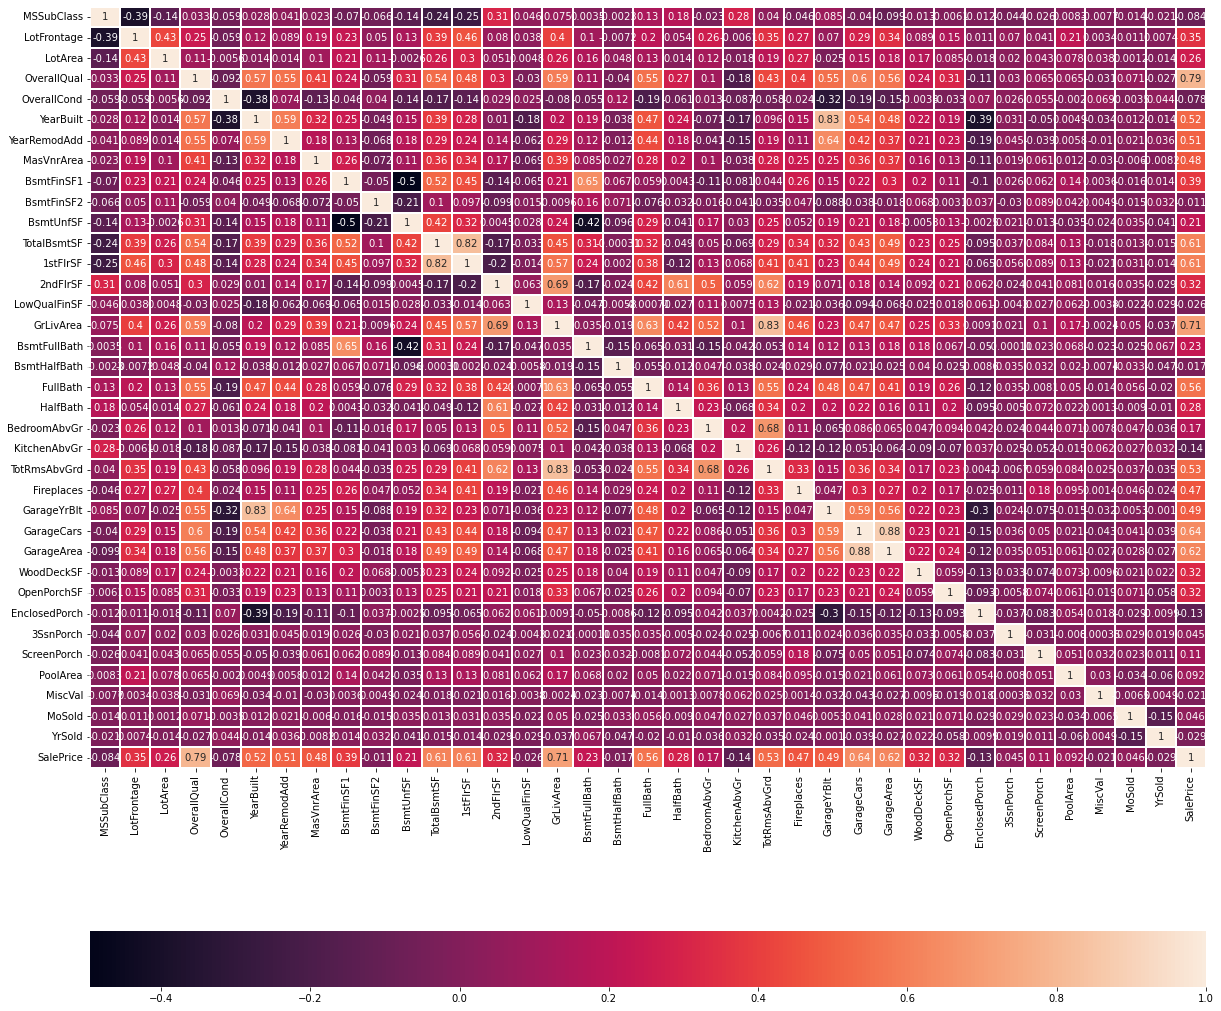

In [36]:
#correlação entre os atributos
corr = dados_treino.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = True, linewidths = 0.1, cbar_kws={"orientation": "horizontal"})

In [83]:
#features com maiores correalações com variável target
top_corr = corr['SalePrice'][abs(corr['SalePrice'] > 0.5)]
top_corr.sort_values(ascending = False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

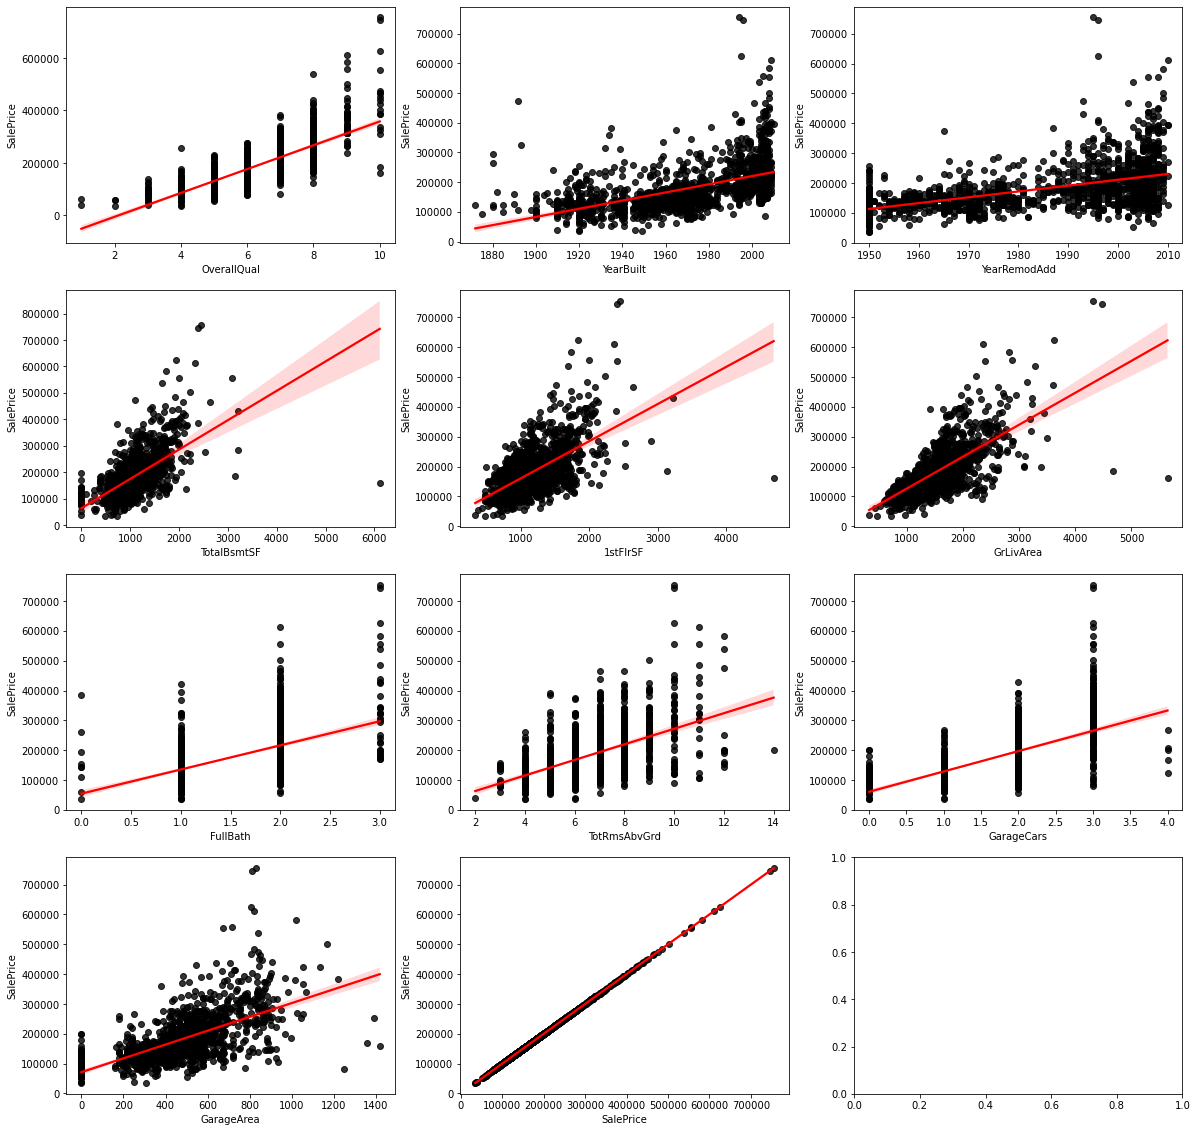

In [74]:
fig, axs = plt.subplots(4,3,figsize=(20,20))
i = 0
for line in range(4):
    for col in range(3):
        sns.regplot(x = dados_treino[top_corr.index[i]], y = dados_treino.SalePrice, 
                    scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax = axs[line][col])
        i += 1
        if i > 10:
            break